# Behavioural Data Cleaning, Processing, and Preliminary Analysis

The purpose of this code is to read in and process the behavioural data from the Threat and Security Notifications (TSN) study. This script is meant for initial data cleaning and visual comparison of the results. 

## Load necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import statsmodels
from statsmodels.stats.anova import AnovaRM
import scipy.stats as st
import seaborn as sns

## Read in .csv data

In [2]:
#Read in and concatenate columns/rows from .csv files for concurrent ratings (during EEG)
df = pd.concat([pd.read_csv(f, 
                            usecols = ['participant',
                                       'cur_section',
                                       'cur_block',
                                       'PicStim',
                                       'pic_type',
                                       'cur_pic',
                                       'cur_rating',
                                       'RateDelay',
                                       'ITI',
                                       'ratingValence.response',
                                       'ratingArousal.response',
                                       'ratingValence.rt',
                                       'ratingArousal.rt'], 
                            skiprows = [i for i in range(1,9)], nrows = 194)
                    for f in glob.glob('../Data/behav_raw/Part*.csv')])

#Get rid of empty rows, which occur every five pictures due to the loop restarting
df = df.dropna(subset=['PicStim'])

#Reset the index
df = df.reset_index(drop=True)

#Rename rating variables
df = df.rename({'ratingValence.response':'Valence', 
                'ratingArousal.response':'Arousal'},
                         axis='columns')

#Have a look and see if it looks right:
print(df)

     pic_type  RateDelay  ITI  Valence  ratingValence.rt  Arousal  \
0        posi        3.0  2.2      2.0             2.467      3.0   
1        warn        2.4  2.7      2.0             1.162      4.0   
2        onli        2.6  2.6      3.0             0.962      1.0   
3        nega        2.4  2.3      2.0             1.367      3.0   
4        neut        2.3  3.0      3.0             0.645      1.0   
...       ...        ...  ...      ...               ...      ...   
3355     neut        2.7  2.9      5.0             1.529      1.0   
3356     warn        2.3  2.3      1.0             1.795      2.0   
3357     onli        2.0  2.7      3.0             0.828      3.0   
3358     posi        2.3  2.7      2.0             1.400      3.0   
3359     nega        2.0  2.2      2.0             1.329      3.0   

      ratingArousal.rt  cur_section  cur_block                    PicStim  \
0                2.579          1.0        1.0      pics160/happy8041.jpg   
1                

## Summary Statistics

## Export for analysis
Python doesn't seem to have a great library for the clm model. We need to export this dataframe and analyze it using R.

In [3]:
df.to_csv("sam_responses.csv")

## Group-Level Statistics

In [4]:
# Get average valence and arousal per participant and write it to a new df.

df_aov = df.groupby(['participant','pic_type'], as_index=True).agg(
                                    Valence_ave=pd.NamedAgg(column='Valence', aggfunc=np.mean),
                                    Valence_std=pd.NamedAgg(column='Valence', aggfunc=np.std),
                                    Arousal_ave=pd.NamedAgg(column='Arousal', aggfunc=np.mean),
                                    Arousal_std=pd.NamedAgg(column='Arousal', aggfunc=np.std)
                                      ).reset_index()

print(df_aov)

        participant pic_type  Valence_ave  Valence_std  Arousal_ave  \
0    Participant_10     nega      1.59375     0.837021      2.87500   
1    Participant_10     neut      3.00000     0.718421      3.12500   
2    Participant_10     onli      2.90625     0.465547      4.00000   
3    Participant_10     posi      3.93750     0.759350      2.78125   
4    Participant_10     warn      2.12500     0.421212      2.12500   
..              ...      ...          ...          ...          ...   
100   Participant_9     nega      1.62500     0.975506      4.21875   
101   Participant_9     neut      3.18750     1.148281      2.56250   
102   Participant_9     onli      3.50000     0.762001      2.43750   
103   Participant_9     posi      4.21875     1.069651      2.12500   
104   Participant_9     warn      1.25000     0.879883      4.15625   

     Arousal_std  
0       1.128802  
1       1.718026  
2       1.565763  
3       1.156591  
4       1.338029  
..           ...  
100     1.1283

In [5]:
# Get average valence and arousal and write it to a new df.

df_ave = df.groupby(['pic_type']).agg(Valence_ave=pd.NamedAgg(column='Valence', aggfunc=np.mean),
                                    Valence_std=pd.NamedAgg(column='Valence', aggfunc=np.std),
                                    Arousal_ave=pd.NamedAgg(column='Arousal', aggfunc=np.mean),
                                    Arousal_std=pd.NamedAgg(column='Arousal', aggfunc=np.std)
                                      )

print(df_ave)

          Valence_ave  Valence_std  Arousal_ave  Arousal_std
pic_type                                                    
nega         1.915179     0.859908     3.194940     1.245835
neut         3.038690     0.733481     2.002976     1.133420
onli         3.043155     0.592739     1.872024     1.023563
posi         3.885417     0.815441     2.126488     1.160867
warn         2.247024     0.658538     2.544643     1.068908


## Visual Analysis

#### Get confidence intervals of valence for each condition

In [6]:
conditions = ["nega","neut","onli","posi","warn"]
valence_ci_min = []
valence_ci_max = []

for cond in conditions:
    val = df[df.pic_type == cond]["Valence"]
    ci = st.t.interval(alpha=0.95, df=len(val)-1, loc=np.mean(val), scale=st.sem(val))
    valence_ci_min.append(ci[0])
    valence_ci_max.append(ci[1])

In [7]:
df_ave["Valence_ci_min"] = valence_ci_min
df_ave["Valence_ci_max"] = valence_ci_max
df_ave["Valence_ci_diff"] = df_ave["Valence_ave"] - df_ave["Valence_ci_min"]

In [8]:
df_ave

,Valence_ave,Valence_std,Arousal_ave,Arousal_std,Valence_ci_min,Valence_ci_max,Valence_ci_diff
pic_type,,,,,,,
nega,1.915179,0.859908,3.194940,1.245835,1.850046,1.980311,0.065133
neut,3.038690,0.733481,2.002976,1.133420,2.983134,3.094247,0.055557
onli,3.043155,0.592739,1.872024,1.023563,2.998258,3.088051,0.044896
posi,3.885417,0.815441,2.126488,1.160867,3.823652,3.947181,0.061765
warn,2.247024,0.658538,2.544643,1.068908,2.197144,2.296904,0.049880


#### Graph of average valence by pictype

In [9]:
sns.set_theme(style="darkgrid")

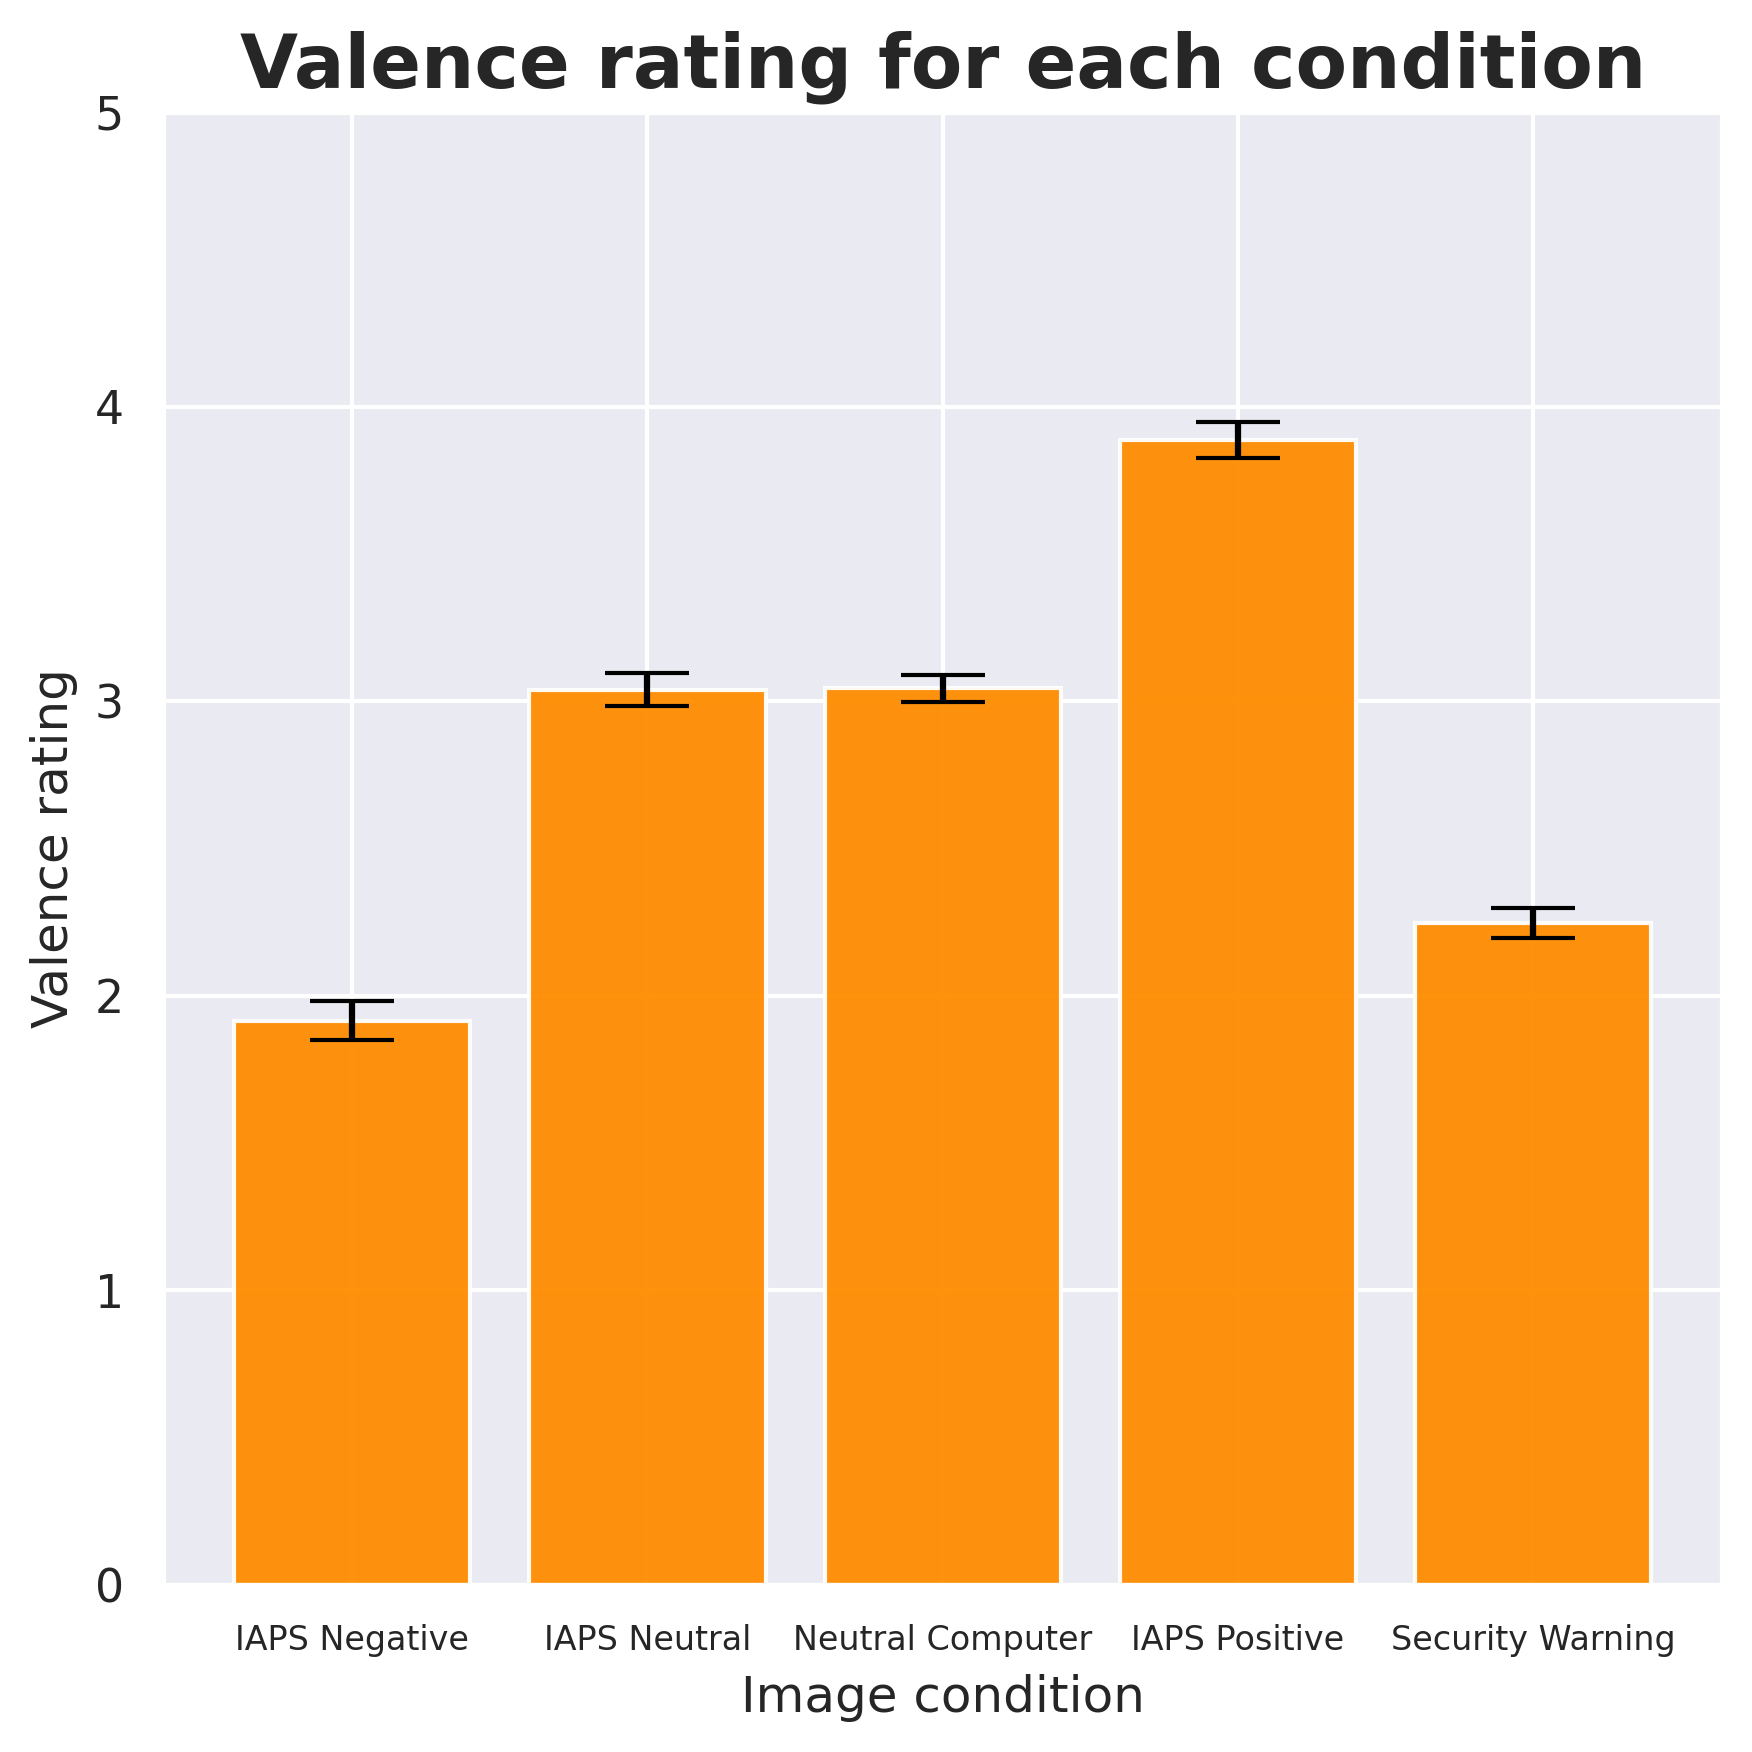

In [10]:
# Create lists for the plot (copied values from the averaged table above)
pictype = ['IAPS Negative', 'IAPS Neutral', 'Neutral Computer', 'IAPS Positive', 'Security Warning']
x_pos = np.arange(len(pictype))

rating = df_ave["Valence_ave"]
confidence = df_ave["Valence_ci_diff"]

# Build the plot
fig, ax = plt.subplots(figsize=(6, 6), dpi= 300, facecolor='w', edgecolor='k')
ax.bar(x_pos, rating, yerr=confidence, align='center', alpha=0.95, color='darkorange', ecolor='black', capsize=10)
ax.set_xlabel('Image condition', fontsize=12)
ax.set_ylabel('Valence rating', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(pictype, fontsize=8)

# Save the figure and show
plt.title("Valence rating for each condition", fontsize=18, weight='bold')
plt.ylim(0,5)
plt.tight_layout()
plt.dpi = 300
plt.savefig('fig4_valence.png')
plt.show()

### Arousal by pictype

#### Get confidence intervals of arousal for each condition

In [11]:
conditions = ["nega","neut","onli","posi","warn"]
arousal_ci_min = []
arousal_ci_max = []

for cond in conditions:
    val = df[df.pic_type == cond]["Arousal"]
    ci = st.t.interval(alpha=0.95, df=len(val)-1, loc=np.mean(val), scale=st.sem(val))
    arousal_ci_min.append(ci[0])
    arousal_ci_max.append(ci[1])

In [12]:
df_ave["Arousal_ci_min"] = arousal_ci_min
df_ave["Arousal_ci_max"] = arousal_ci_max
df_ave["Arousal_ci_diff"] = df_ave["Arousal_ave"] - df_ave["Arousal_ci_min"]

In [13]:
df_ave

,Valence_ave,Valence_std,Arousal_ave,Arousal_std,Valence_ci_min,Valence_ci_max,Valence_ci_diff,Arousal_ci_min,Arousal_ci_max,Arousal_ci_diff
pic_type,,,,,,,,,,
nega,1.915179,0.859908,3.194940,1.245835,1.850046,1.980311,0.065133,3.100576,3.289305,0.094364
neut,3.038690,0.733481,2.002976,1.133420,2.983134,3.094247,0.055557,1.917127,2.088826,0.085850
onli,3.043155,0.592739,1.872024,1.023563,2.998258,3.088051,0.044896,1.794495,1.949552,0.077529
posi,3.885417,0.815441,2.126488,1.160867,3.823652,3.947181,0.061765,2.038559,2.214417,0.087929
warn,2.247024,0.658538,2.544643,1.068908,2.197144,2.296904,0.049880,2.463680,2.625606,0.080963


#### Graph of average arousal by pictype

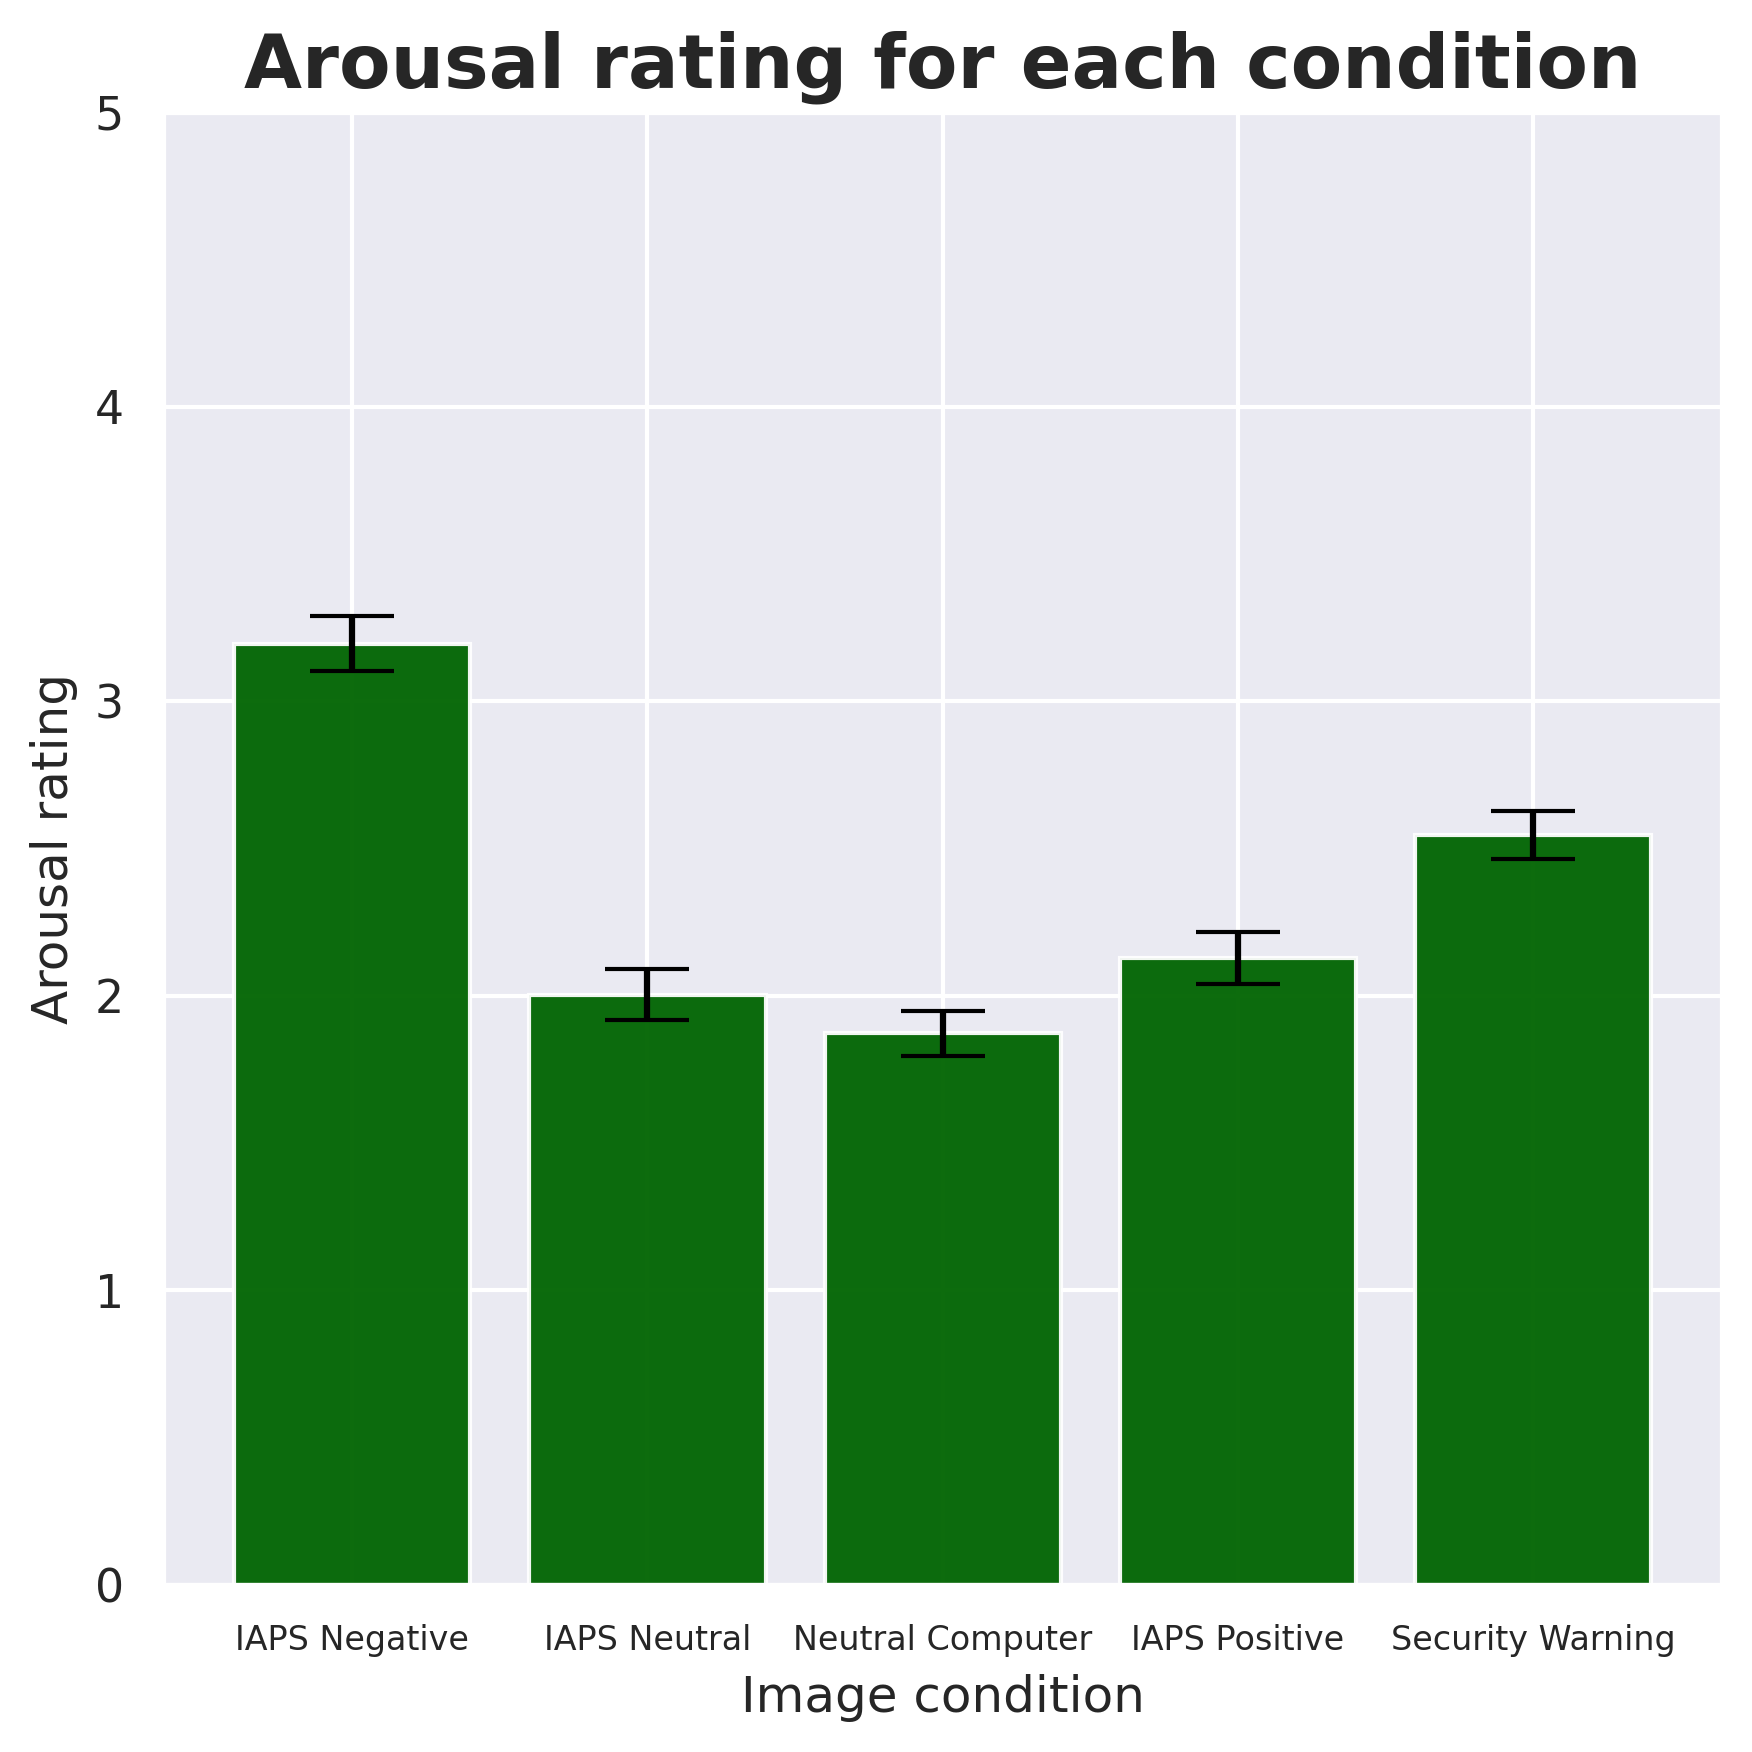

In [14]:
# Create lists for the plot (copied values from the averaged table above)
pictype = ['IAPS Negative', 'IAPS Neutral', 'Neutral Computer', 'IAPS Positive', 'Security Warning']
x_pos = np.arange(len(pictype))

rating = df_ave["Arousal_ave"]
confidence = df_ave["Arousal_ci_diff"]

# Build the plot
fig, ax = plt.subplots(figsize=(6, 6), dpi= 300, facecolor='w', edgecolor='k')
ax.bar(x_pos, rating, yerr=confidence, align='center', alpha=0.95, color='darkgreen', ecolor='black', capsize=10)
ax.set_xlabel('Image condition', fontsize=12)
ax.set_ylabel('Arousal rating', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(pictype, fontsize=8)

# Save the figure and show
plt.title("Arousal rating for each condition", fontsize=18, weight='bold')
plt.ylim(0,5)
plt.tight_layout()
plt.dpi = 300
plt.savefig('fig4_arousal.png')
plt.show()